<a href="https://colab.research.google.com/github/ErdemKilci/ReservoirWind/blob/main/reservoir_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting Project

## Project Goal:
This project aims to analyze and model power consumption based on actual and forecasted loads using machine learning.

## Data Source:
- **Time**
- **Forecast Load**
- **Actual Load**

## Steps Taken So Far:
1. **Data Loading**
2. **Data Cleaning**
3. **Missing Values Analysis**
4. **Basic Data Visualization**
5. **Time-Series Plots**
6. **Error Analysis**

In [24]:
pip install pandas matplotlib openpyxl


## Data Loading and Cleaning
### Goal:
- Read all Excel files
- Merge them into one dataset
- Remove unnecessary rows
- Rename columns
- Convert data types

### Code:

Time range in data: 2014-01-01 00:00:00 to 2024-12-31 23:00:00


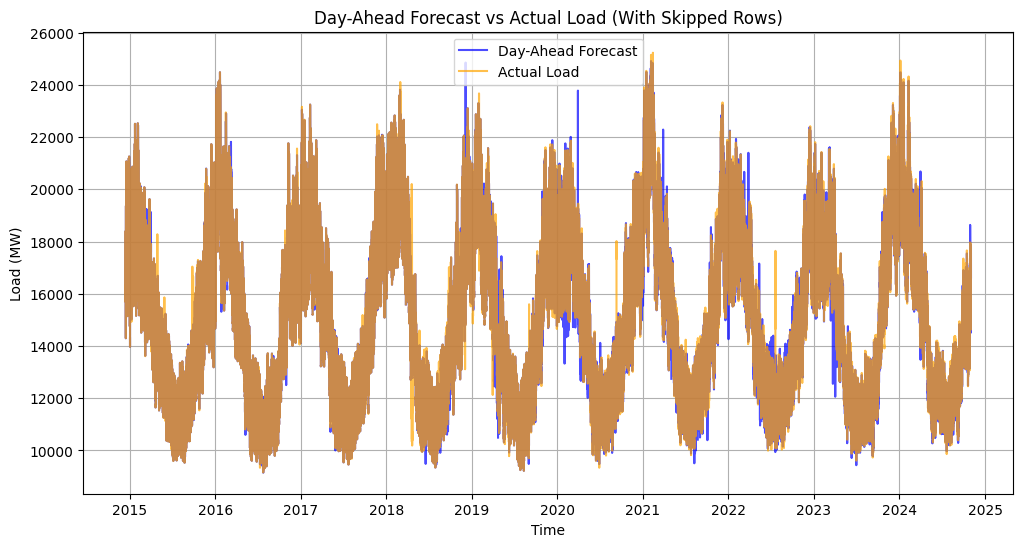

In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Example for file path
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

all_data = pd.DataFrame()

# Manually define the initial start date
current_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file

for file in excel_files:
    file_path = os.path.join(data_folder, file)
    # Read Excel file
    data = pd.read_excel(file_path, skiprows=5)  # Skip metadata rows

    # Rename columns
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Remove the first two rows that don't contain useful data
    data = data.iloc[2:].reset_index(drop=True)

    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic
    filtered_data = pd.DataFrame()
    count = 0  # Counter for rows
    skip = 1  # Tracks rows to be skipped

    for index, row in data.iterrows():
        # If we are in the skipping phase, decrement the skip counter and continue
        if skip > 0:
            skip -= 1
            continue

        # Include the current row in the filtered_data
        filtered_data = pd.concat([filtered_data, pd.DataFrame([row])])
        count += 1

        # Once 24 rows are processed, skip the next 3 rows and reset the counter
        if count == 24:
            skip = 3  # Set skip counter for the next 3 rows
            count = 0  # Reset the counter

    # Generate timestamps dynamically based on the current_datetime
    num_rows = len(filtered_data)
    time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='h')
    filtered_data['Time'] = time_range

    # Update current_datetime to continue from the end of this file's data
    current_datetime = time_range[-1] + pd.Timedelta(hours=1)

    # Convert columns to numeric, preserving NaN values
    filtered_data['Forecast Load'] = pd.to_numeric(filtered_data['Forecast Load'], errors='coerce')
    filtered_data['Actual Load'] = pd.to_numeric(filtered_data['Actual Load'], errors='coerce')

    # Append to the combined DataFrame
    all_data = pd.concat([all_data, filtered_data[['Time', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Verify the range of the data
print("Time range in data:", all_data['Time'].min(), "to", all_data['Time'].max())

# Plot the data, including null values
plt.figure(figsize=(12, 6))
plt.plot(all_data['Time'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Time'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (With Skipped Rows)')
plt.legend()
plt.grid()
plt.show()



## Data Visualization

### Plots Created:
1. Forecast vs Actual Load (Time Series)
2. Yearly Trend Analysis
3. Forecast Error Over Time
4. Missing Data Heatmap


In [26]:
print(data.head())       # Check first few rows
print(data.describe())   # Statistical summary
print(data.isnull().sum())  # Missing values


            Time Forecast Load Actual Load
0  00:00 - 01:00         17872       18350
1  01:00 - 02:00         18118       18364
2  02:00 - 03:00         17993       18224
3  03:00 - 04:00         17851       18030
4  04:00 - 05:00         17827       18009
                 Time Forecast Load Actual Load
count            9150          8784        8784
unique            389          5180        5132
top     02:00 - 03:00             -           -
freq              367          1440        1477
Time              730
Forecast Load    1096
Actual Load      1096
dtype: int64


### Saving Plots Each Year

In [27]:
import os

# Define the folder to save plots relative to your project directory
plot_folder = os.path.join(os.getcwd(), "plots")  # Creates "plots" in the current working directory
all_data['Year'] = all_data['Time'].dt.year

# Create the folder if it doesn't exist
os.makedirs(plot_folder, exist_ok=True)

# Save plots for each year
for year, year_data in all_data.groupby('Year'):
    plt.figure(figsize=(12, 6))
    plt.plot(year_data['Time'], year_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
    plt.plot(year_data['Time'], year_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
    plt.title(f'Day-Ahead Forecast vs Actual Load for {year}')
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.grid()

    # Save the plot in the "plots" folder
    plot_path = os.path.join(plot_folder, f"forecast_vs_actual_{year}.png")
    plt.savefig(plot_path)
    plt.close()

print(f"Plots saved in {plot_folder}")


Plots saved in /content/plots


### Analyse Data Each Year

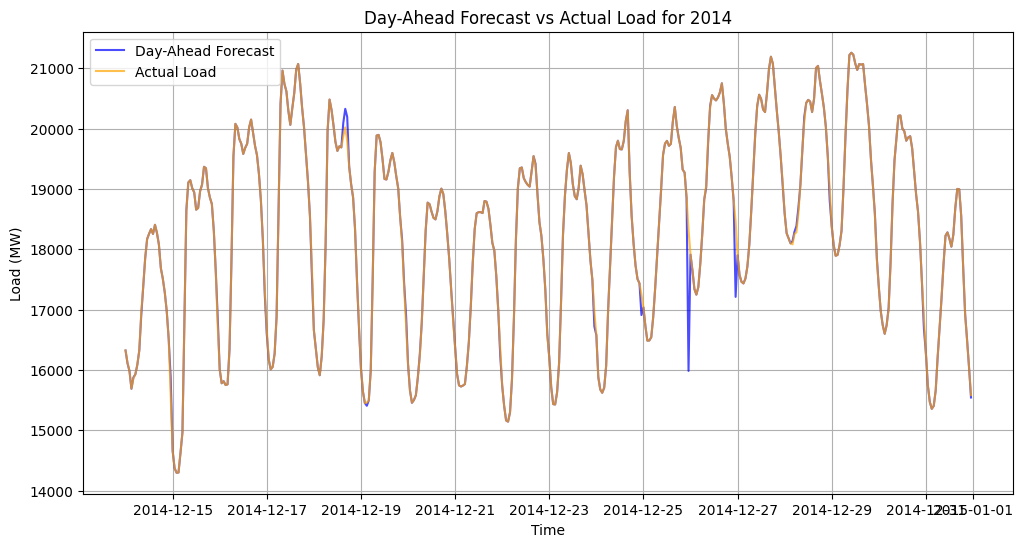

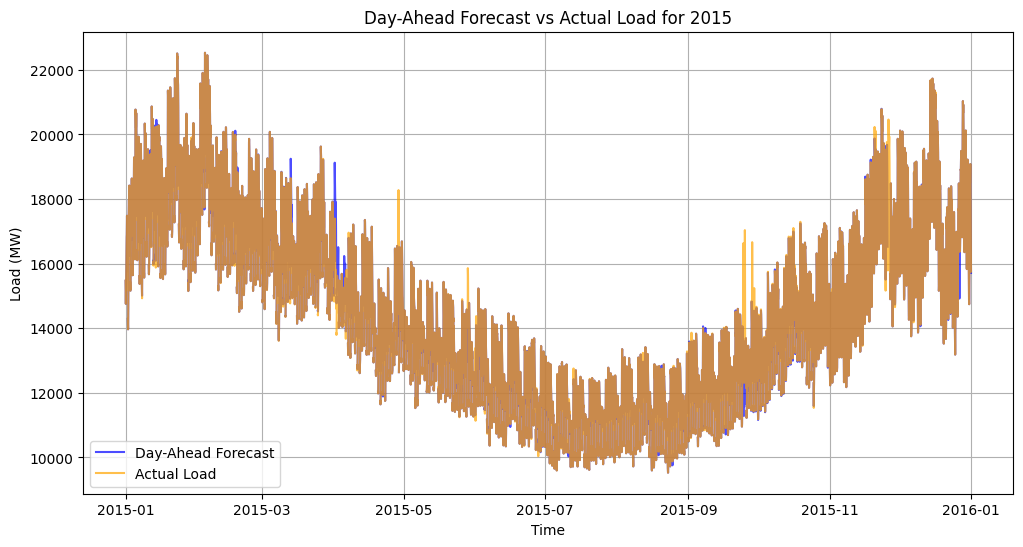

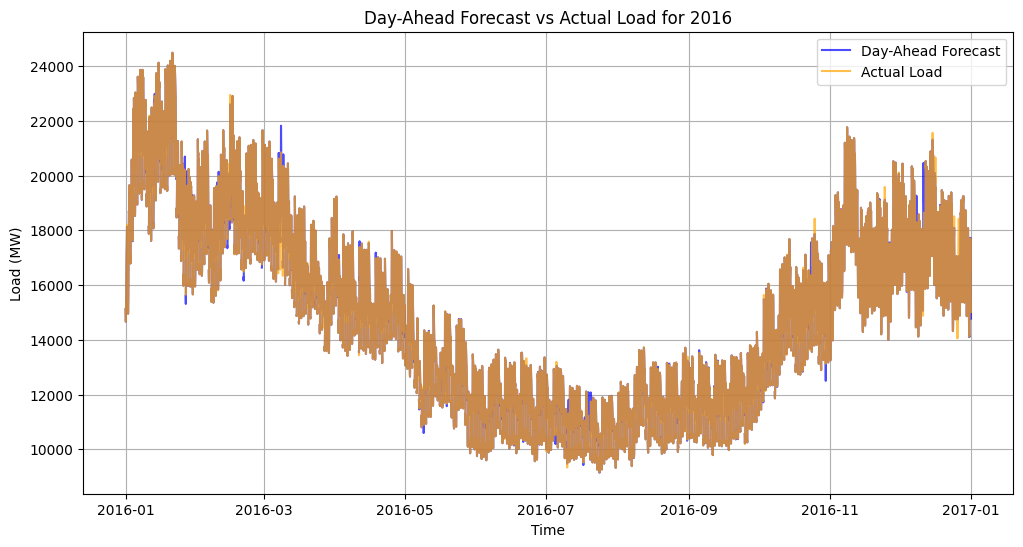

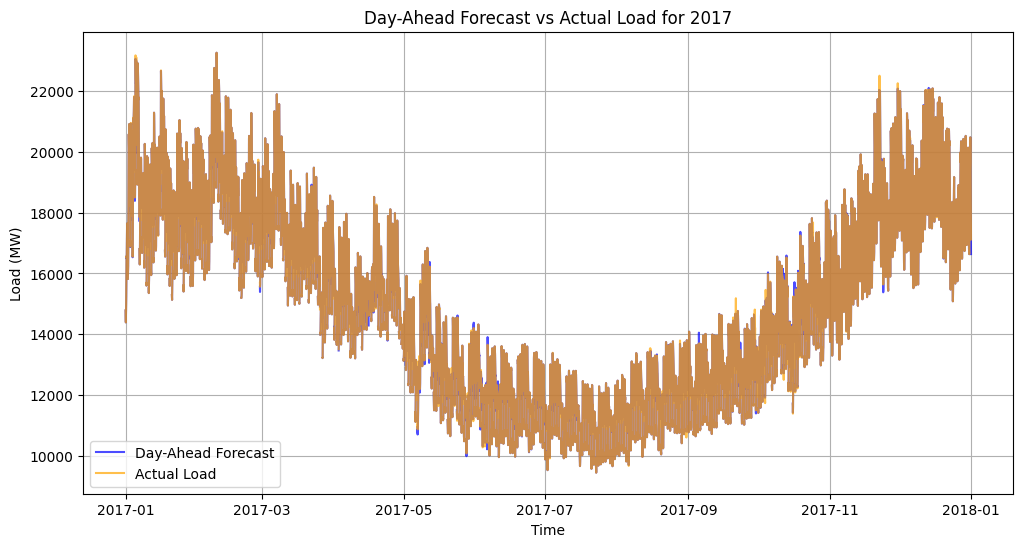

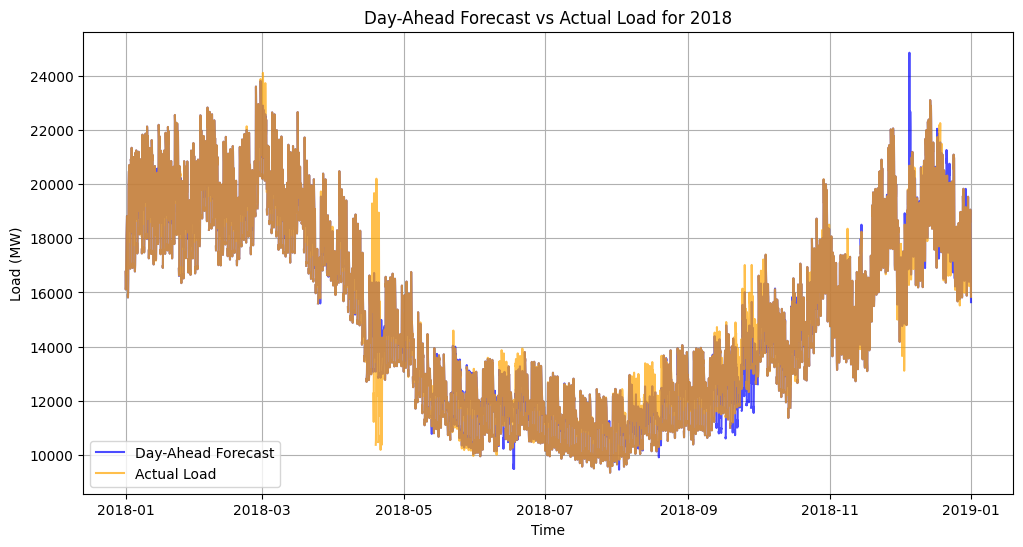

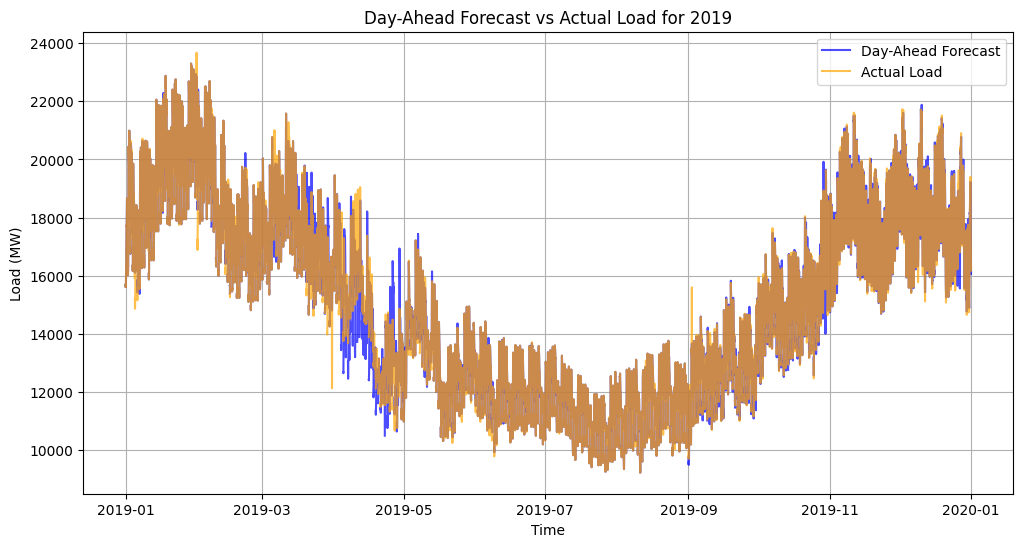

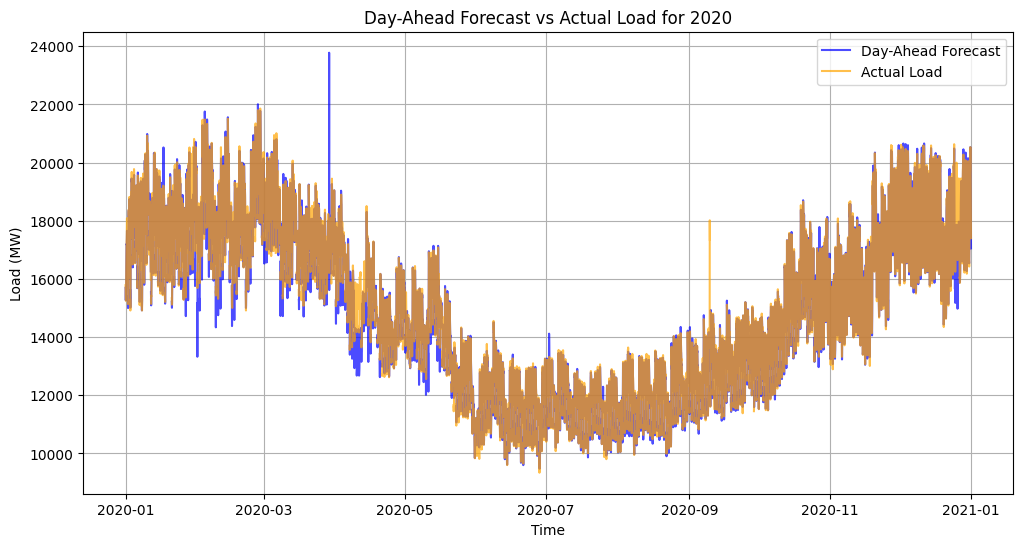

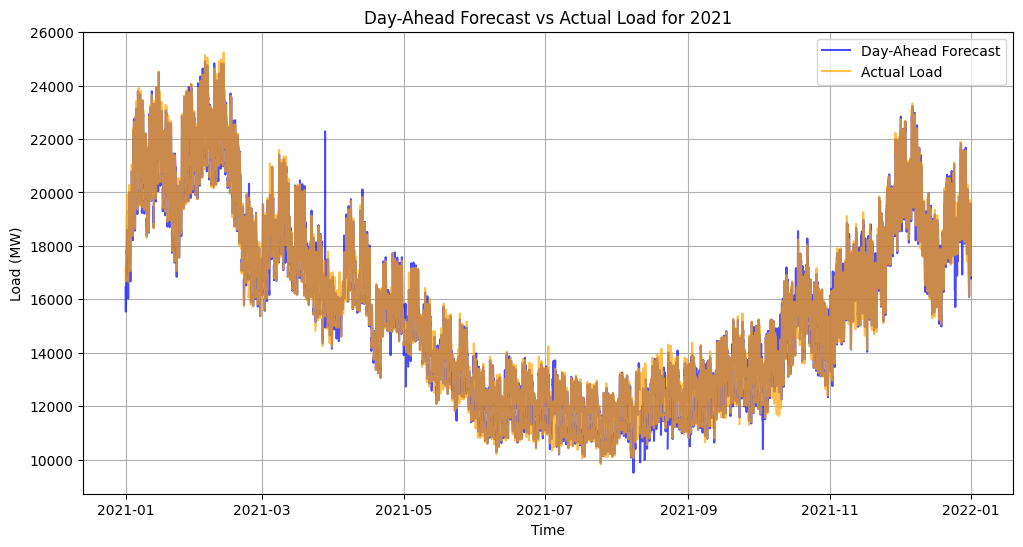

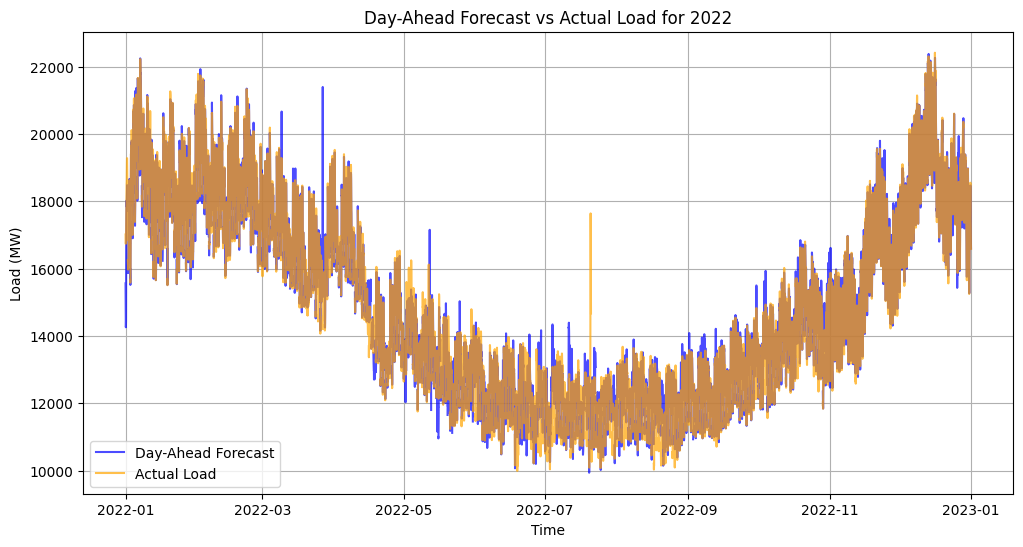

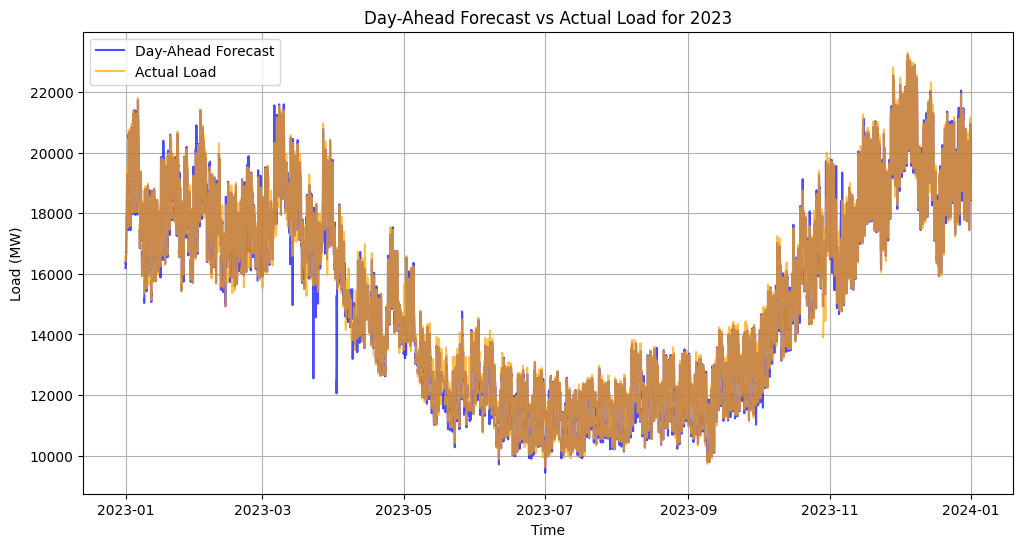

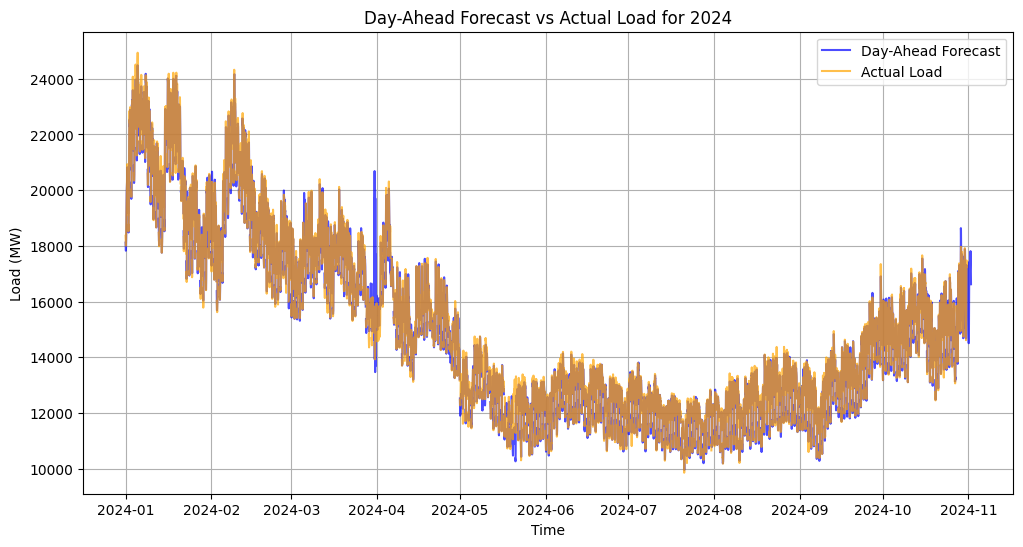

In [28]:
# Group data by year
for year, year_data in all_data.groupby('Year'):
    plt.figure(figsize=(12, 6))
    plt.plot(year_data['Time'], year_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
    plt.plot(year_data['Time'], year_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.title(f'Day-Ahead Forecast vs Actual Load for {year}')
    plt.legend()
    plt.grid()
    plt.show()

### Dahiyane plot

In [29]:
import plotly.graph_objects as go

fig = go.Figure()

# Add Forecast and Actual Load lines
fig.add_trace(go.Scatter(x=all_data['Time'], y=all_data['Forecast Load'],
                         mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=all_data['Time'], y=all_data['Actual Load'],
                         mode='lines', name='Actual Load', line=dict(color='orange')))

# Highlight no-wind periods
no_wind_periods = all_data[(all_data['Forecast Load'].isna()) & (all_data['Actual Load'].isna())]
fig.add_trace(go.Scatter(x=no_wind_periods['Time'], y=[None]*len(no_wind_periods),
                         mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')))

fig.update_layout(
    title='Day-Ahead Forecast vs Actual Load (With Gaps Highlighted)',
    xaxis_title='Time',
    yaxis_title='Load (MW)',
    legend=dict(orientation="h"),
    template='plotly_white'
)

fig.show()

## Exploratory Data Analysis (EDA)

### What we analyzed:
- Summary statistics
- Missing values
- Time range verification

### Summary Statistics

In [30]:
summary_stats = all_data.groupby(all_data['Time'].dt.year).agg({
    'Forecast Load': ['mean', 'max', 'min'],
    'Actual Load': ['mean', 'max', 'min']
})
print(summary_stats)



     Forecast Load                     Actual Load                  
              mean      max      min          mean      max      min
Time                                                                
2014  18320.942130  21258.0  14295.0  18327.513889  21258.0  14296.0
2015  14737.266177  22531.0   9527.0  14747.043252  22530.0   9527.0
2016  15133.894929  24485.0   9147.0  15130.734168  24485.0   9157.0
2017  15233.730314  23246.0   9458.0  15232.565145  23246.0   9457.0
2018  15458.178745  24854.0   9342.0  15525.287268  24108.0   9343.0
2019  15286.774704  23300.0   9217.0  15298.370922  23672.0   9217.0
2020  15153.678491  23779.0   9476.0  15178.200354  21861.0   9338.0
2021  15885.584674  24911.0   9508.0  15911.168283  25230.0   9820.0
2022  15063.783848  22379.0   9938.0  15071.378148  22416.0   9992.0
2023  15369.995744  23229.0   9435.0  15409.937810  23305.0   9608.0
2024  15097.804203  24480.0   9965.0  15118.694976  24930.0   9862.0


### Comment Summary stats
burasini inceledigmizde goruyoruz ki 2014 yilinin gunde en az harcandigi enerji miktarri 14295.0
lakin diger yillara baktigimizda 2015 ve sonrasi icin geneli 9500 kusurde. Bunun nedeni 2014 yilinin sadece aralik ayinin degerlendirilmesi diger verilerin olmamasi yani yaz ve kis kiyaslamasi yok.



### Saving Processed Data

In [31]:
all_data.to_csv('combined_data.csv', index=False)


### Handle Missing Data

In [32]:
print("Missing Values Summary:")
print(all_data.isnull().sum())


Missing Values Summary:
Time                 0
Forecast Load    12806
Actual Load      12835
Year                 0
dtype: int64


### Anomalies

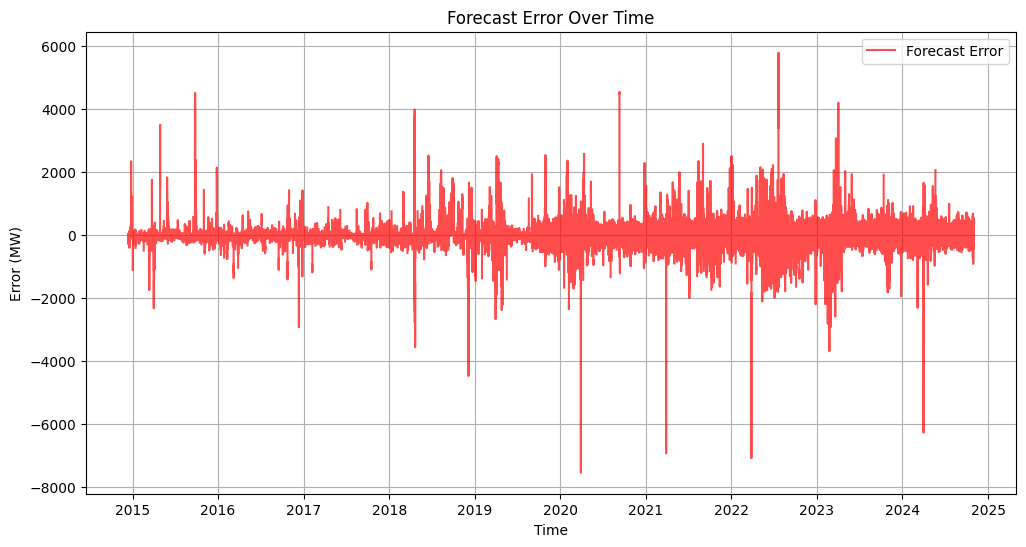

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(all_data['Time'], all_data['Actual Load'] - all_data['Forecast Load'], label='Forecast Error', alpha=0.7, color='red')
plt.xlabel('Time')
plt.ylabel('Error (MW)')
plt.title('Forecast Error Over Time')
plt.legend()
plt.grid()
plt.show()


### monthly average with group by structure

In [34]:
'''# Ensure 'Time' is in datetime format
all_data['Time'] = pd.to_datetime(all_data['Time'], errors='coerce')

# Extract 'Year' and 'Month'
all_data['Year'] = all_data['Time'].dt.year
all_data['Month'] = all_data['Time'].dt.month

# Group by 'Year' and 'Month' and calculate averages
monthly_avg = all_data.groupby(['Year', 'Month'], as_index=True)[['Forecast Load', 'Actual Load']].mean()

# Display the result
print(monthly_avg)
'''


"# Ensure 'Time' is in datetime format\nall_data['Time'] = pd.to_datetime(all_data['Time'], errors='coerce')\n\n# Extract 'Year' and 'Month'\nall_data['Year'] = all_data['Time'].dt.year\nall_data['Month'] = all_data['Time'].dt.month\n\n# Group by 'Year' and 'Month' and calculate averages\nmonthly_avg = all_data.groupby(['Year', 'Month'], as_index=True)[['Forecast Load', 'Actual Load']].mean()\n\n# Display the result\nprint(monthly_avg)\n"

In [35]:
'''import matplotlib.pyplot as plt
import seaborn as sns

# Setting up for visualization aesthetics
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Sample size for demonstration (if the dataset is too large)
sample_data = data.sample(10000) if len(data) > 10000 else data
'''

'import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Setting up for visualization aesthetics\nplt.style.use(\'ggplot\')\nsns.set_theme(style="whitegrid")\n\n# Sample size for demonstration (if the dataset is too large)\nsample_data = data.sample(10000) if len(data) > 10000 else data\n'

In [36]:
'''sample_data = all_data.sample(10000) if len(all_data) > 10000 else all_data
sample_data = sample_data.reset_index(drop=True)  # Reset index for clarity
'''


'sample_data = all_data.sample(10000) if len(all_data) > 10000 else all_data\nsample_data = sample_data.reset_index(drop=True)  # Reset index for clarity\n'

### Mising values percentage

In [37]:
# Check total null value
missing_values = all_data.isnull().sum()
missing_percentage = (missing_values/len(all_data))*100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_summary)

               Missing Values  Percentage
Time                        0    0.000000
Forecast Load           12806   13.279824
Actual Load             12835   13.309897
Year                        0    0.000000


### Mising Data Heat Map

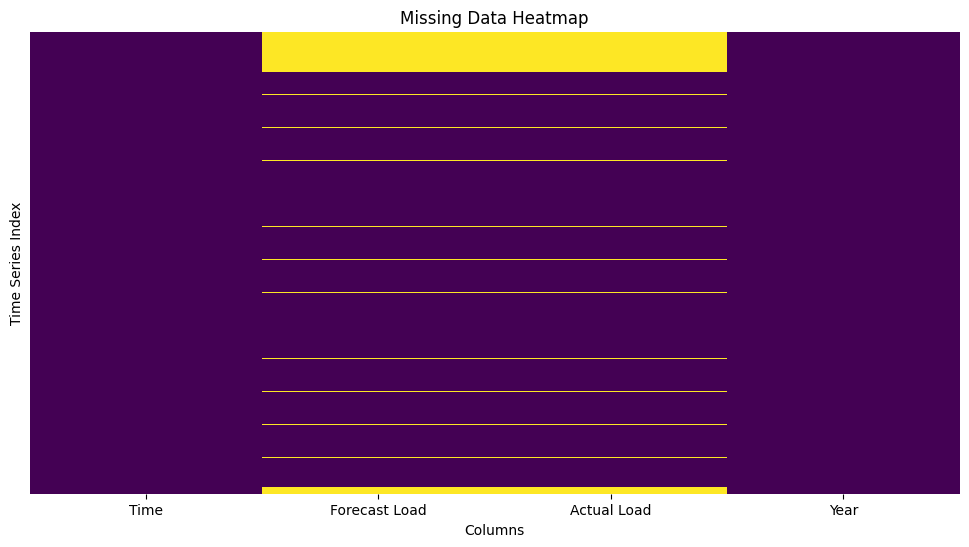

      Time  Forecast Load  Actual Load  Year
Time                                        
2014     0           8328         8328     0
2015     0            322          298     0
2016     0            304          320     0
2017     0            302          302     0
2018     0            301          301     0
2019     0            300          300     0
2020     0            299          299     0
2021     0            304          304     0
2022     0            303          303     0
2023     0            302          302     0
2024     0           1741         1778     0


In [38]:
# Step 1: Identify missing value patterns over time
plt.figure(figsize=(12, 6))
sns.heatmap(all_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Time Series Index")
plt.show()

# Step 2: Check missing values by year
missing_by_year = all_data.groupby(all_data['Time'].dt.year).apply(lambda x: x.isnull().sum())
print(missing_by_year)


## Next Steps

**Completed:**
 Data Cleaning
 Data Exploration
 Basic Visualization

**To Do Next:**
 Feature Engineering (Rolling Averages, Lag Features)
 Outlier Detection & Handling
 Correlation Analysis
 Seasonality & Trend Analysis
 Data Imbalance Check


## Feature Engineering

### Why is Feature Engineering Important?
To improve forecasting accuracy, we create new time-dependent features such as:
- **Lag Features:** Previous values (e.g., `t-1`, `t-24`) to capture trends.
- **Rolling Averages:** Smooth short-term fluctuations.

### Steps:
1. Compute lag features.
2. Calculate rolling averages.
3. Add day-of-week and month indicators.


In [39]:
### *Feature Enginering Code Below:*

## Outlier Detection

### Why is it Important?
Outliers can distort predictions and must be identified.

### Steps:
1. **Visualize using Box Plots**
2. **Compute Z-Scores or IQR**
3. **Decide: Remove or Transform?**


In [40]:
### *Outlier Detection Code Below:*

## Correlation Analysis

### Why is it Important?
Identifying relationships between variables helps remove redundancy.

### Steps:
1. Compute correlation matrix.
2. Visualize with a heatmap.
3. Identify highly correlated features.


In [41]:
### *Correlation Analysis Code Below:*

## Time-Series Decomposition

### Why?
- Helps visualize long-term trends.
- Identifies seasonal patterns.

### Steps:
1. Use `seasonal_decompose()`.
2. Plot components (Trend, Seasonality, Residuals).
3. Decide if detrending is needed.


In [42]:
### *Time Series Decomposition Code Below:*